# Comparison of an SMPI trace with a real trace for HPL

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    return df, df_links

reality_file = 'grenoble_2018-12-07_1825200.zip'
simgrid_file = '../smpi_hpl/grenoble_2018-12-07_1825198.zip'

trace_reality, link_reality = read_archive(reality_file, 'reality')
trace_simgrid, link_simgrid = read_archive(simgrid_file, 'simgrid')
traces = pandas.concat([trace_reality, trace_simgrid])

traces.head()

# Mode: reality
	BLAS trace:   3562 lines
	MPI  trace:  20984 lines
Removed 4090 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace:   3372 lines
	MPI  trace:  10020 lines
Removed 16 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1
0,174.360027,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,174.360,reality,1
1,174.360282,dgemm,2.0,BLAS,125054.0,-1,2.0,0,174.360,reality,1
2,174.361000,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,174.361,reality,1
3,174.361001,dgemm,2.0,BLAS,125052.0,-1,0.0,0,174.361,reality,1
4,174.361002,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,174.361,reality,1


## Checking the parameters

In [2]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,2,4,1,2,2,1,0,8,1,32


In [3]:
read_csv(simgrid_file, 'exp_smpi.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,250000,128,2,4,1,2,2,1,0,8,1,32,2.548998e-12,0.000099,4.524788e-12,0.00004


In [4]:
print(zipfile.ZipFile(simgrid_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

In [5]:
for mode in traces['mode'].unique():
    for kind in trace_reality['kind'].unique():
        df = traces[(traces['mode'] == mode) & (traces['kind'] == kind)]
        print(mode, kind, df.start.min(), df.end.max())

reality BLAS 174.36 190.12937000000002
reality MPI 4.2e-05 432.767941
simgrid BLAS 0.095161 13.032350000000001
simgrid MPI 0.0 13.044286999999999


## Visualizing the traces

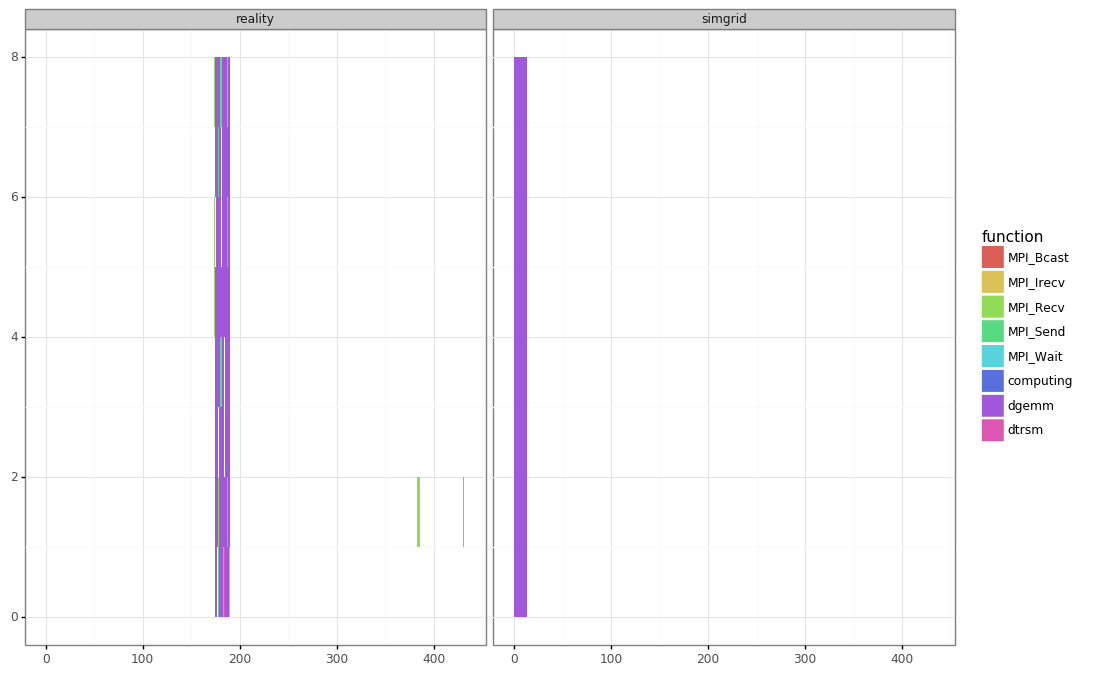

<ggplot: (8792574011996)>

In [6]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

plot(traces, ['mode'])

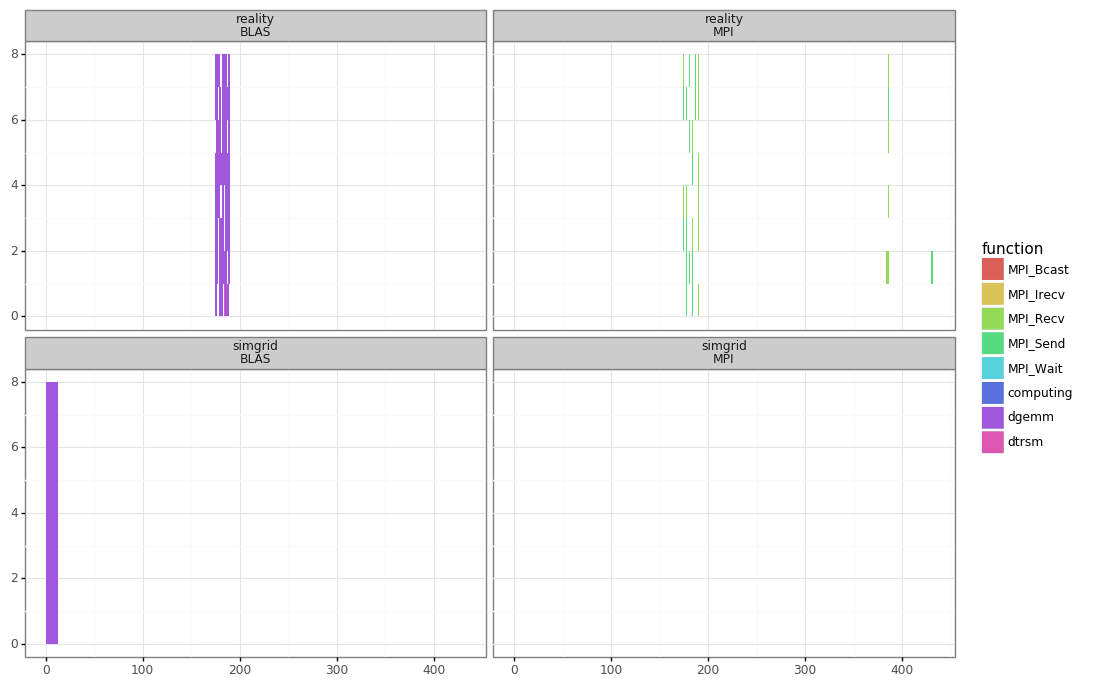

<ggplot: (8792565766860)>

In [7]:
plot(traces)

### Removing the initialization and the finalization in the traces

In [8]:
def split(df):
    return [df[df['rank'] == rank] for rank in df['rank'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    return df[(df['start'] > start) & (df['end'] < end)]

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

In [9]:
trace_simgrid = crop_all(trace_simgrid, 'MPI_Bcast')
trace_reality = crop_all(trace_reality, 'MPI_Bcast')
traces = pandas.concat([trace_simgrid, trace_reality])

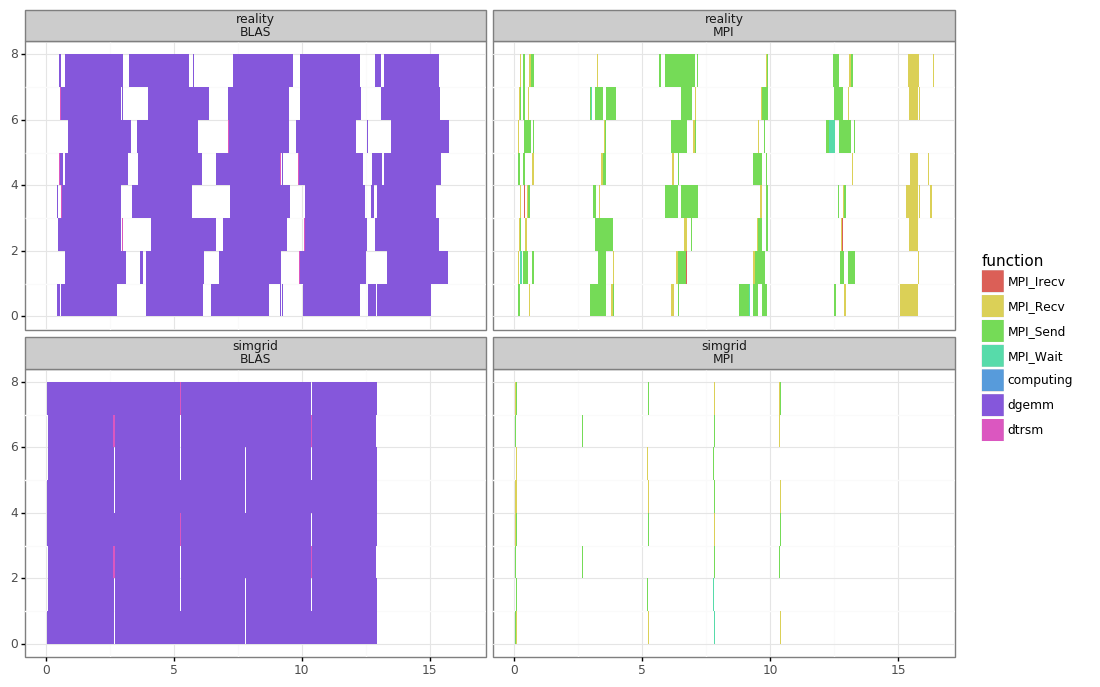

<ggplot: (-9223363244288500771)>

In [10]:
plot(traces)

### Zooming on the trace 

In [11]:
def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

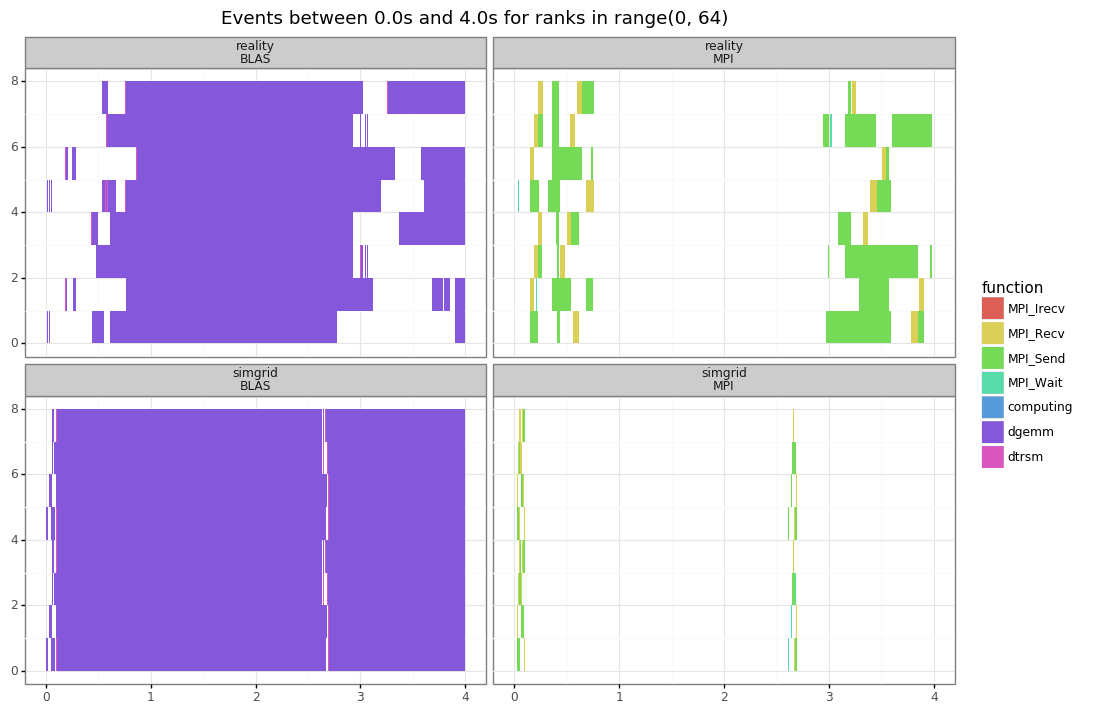

<ggplot: (-9223363244308906471)>

In [12]:
plot_bounded(traces, 0, 4, range(64))

## Plotting the links

In [13]:
def draw_plot(state_dataframe, link_dataframe, time_interval=None, ranks=None):
    if time_interval is None:
        time_interval = -float('inf'), float('inf')
        time_str = 'for the whole experiment'
    else:
        time_str = 'between %.1fs and %.1fs' % time_interval
    if ranks is None:
        ranks = range(0, 1000000)
        rank_str = 'for all the ranks'
    else:
        rank_str = 'for ranks in %s' % ranks
    tmp_state = state_dataframe[(state_dataframe['start'] >= time_interval[0]) & (state_dataframe['end'] <= time_interval[1]) & (state_dataframe['rank'].isin(ranks))].copy()
    tmp_state['rank+1'] = tmp_state['rank'] + 1
    tmp_link = link_dataframe[(link_dataframe['start'] >= time_interval[0]) & (link_dataframe['end'] <= time_interval[1]) & (link_dataframe['src'].isin(ranks)) & (link_dataframe['dst'].isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme() + ggtitle('Events %s %s' % (time_str, rank_str))
#    for i in set((tmp_state['rank'] // 32)*32):
#        if i <= 0:
#            continue
#        gc += geom_hline(yintercept=i, linetype='dashed', color='red')
    print(gc)
#    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst', color='remote'), arrow = arrow(length = 0.1))
    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst'), arrow = arrow(length = 0.1))
    print(gc)

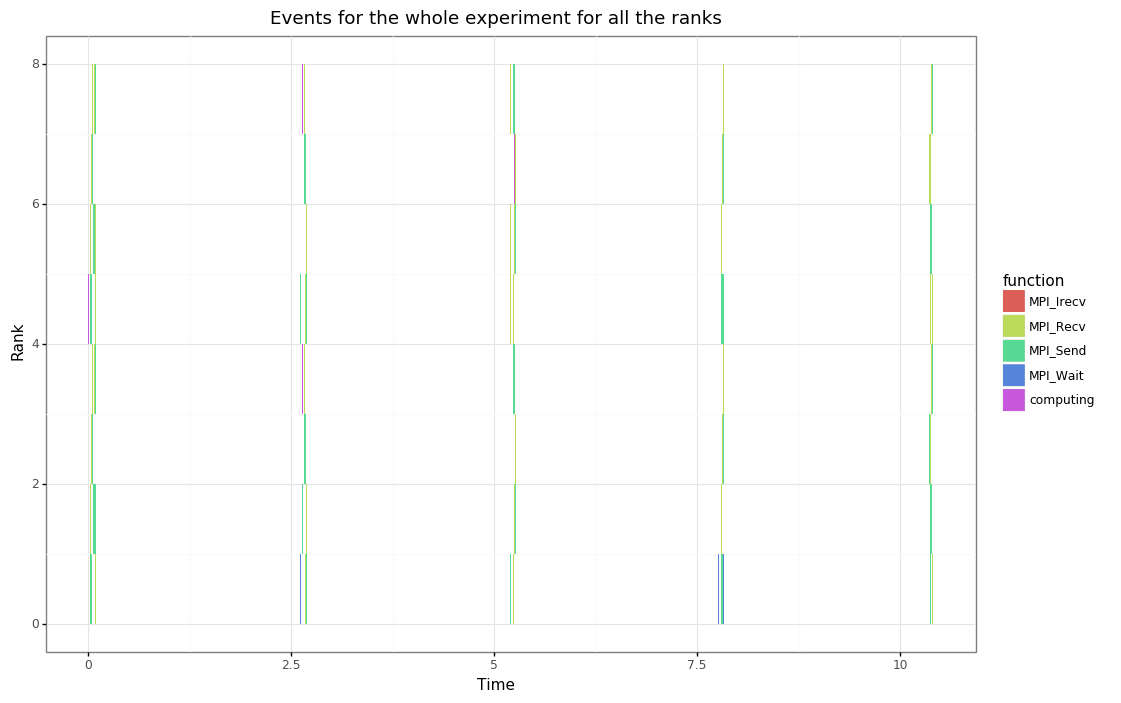

<ggplot: (-9223363244309000283)>


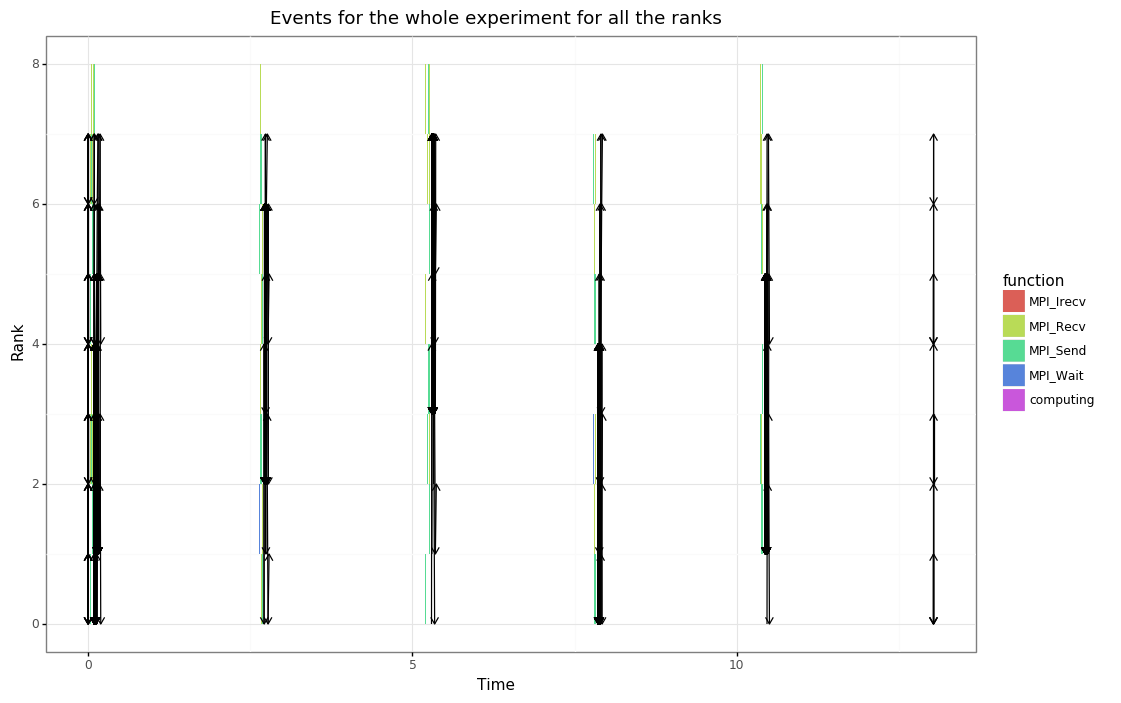

<ggplot: (-9223363244309000283)>


In [14]:
draw_plot(trace_simgrid[trace_simgrid['kind'] == 'MPI'], link_simgrid)

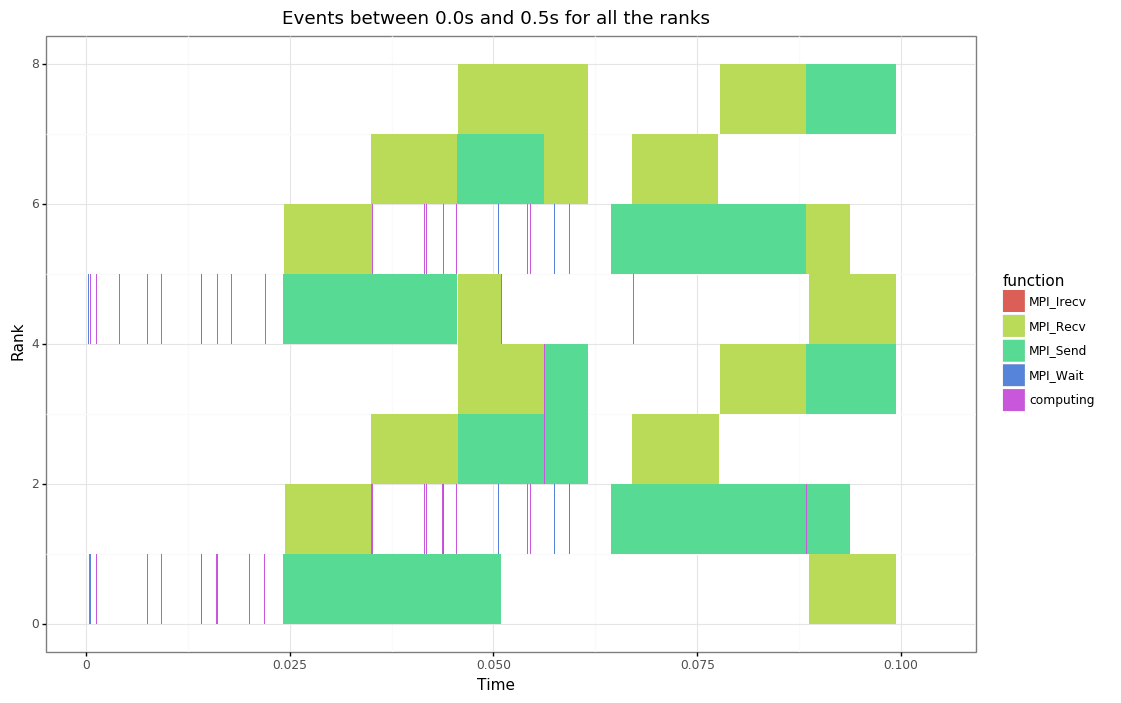

<ggplot: (-9223363244344906587)>


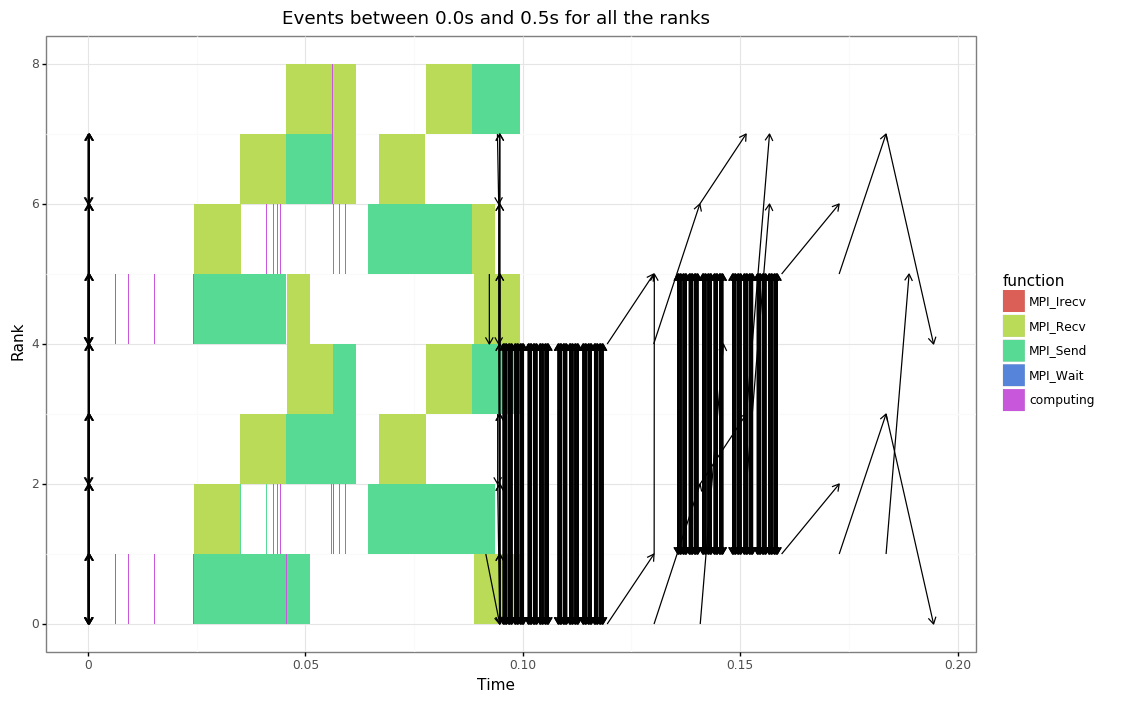

<ggplot: (-9223363244344906587)>


In [15]:
draw_plot(trace_simgrid[trace_simgrid['kind'] == 'MPI'], link_simgrid, time_interval=(0, 0.5))

## Plotting the total time spent in each function

In [16]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end']].copy()
    df['duration'] = df['end'] - df['start']
    df = df.groupby(['rank', 'mode']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='mode')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    df_reality = df[df['mode'] == 'reality']
    df_simgrid = df[df['mode'] == 'simgrid']
    df = df_reality.set_index('rank').join(df_simgrid.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

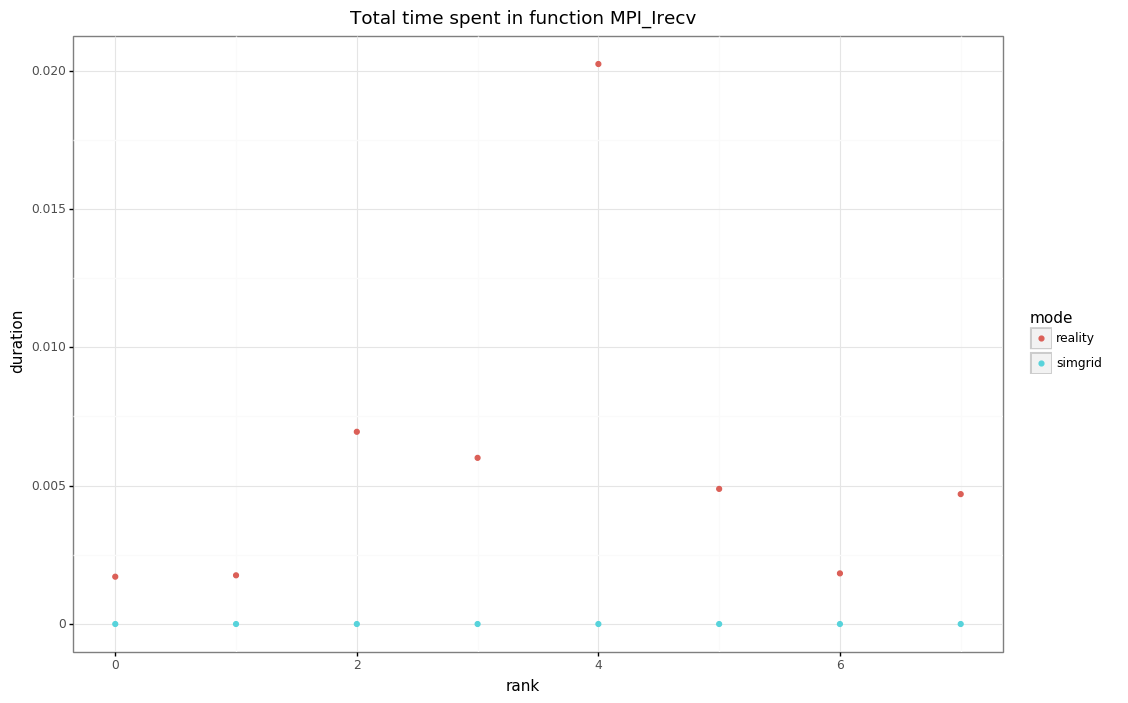

<ggplot: (-9223363244343629203)>


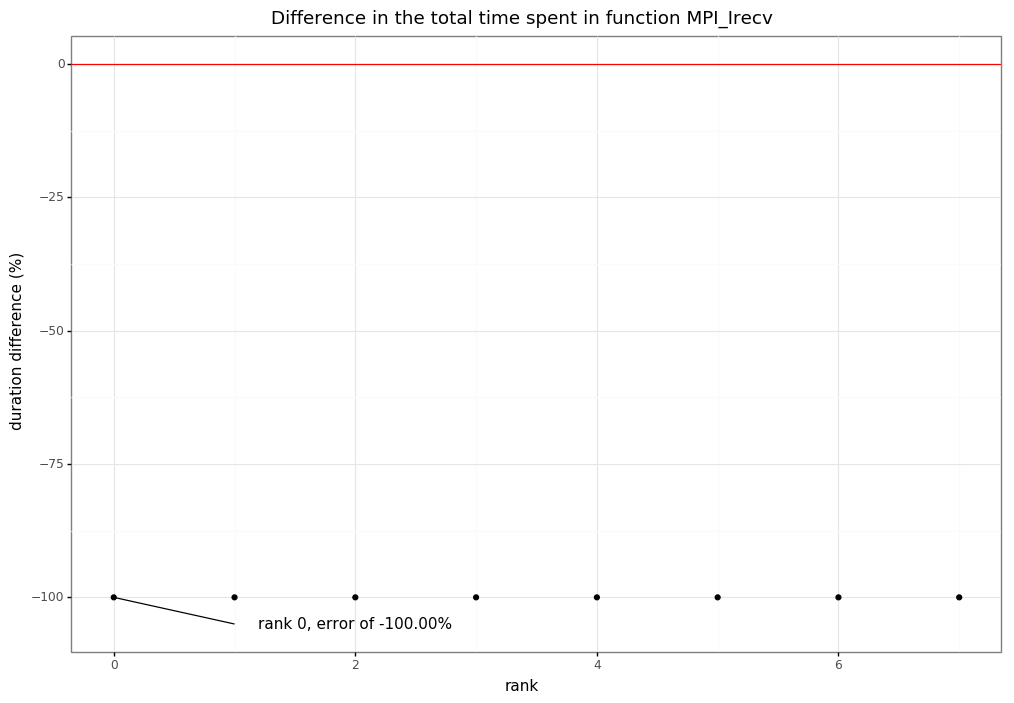

<ggplot: (-9223363244309014433)>


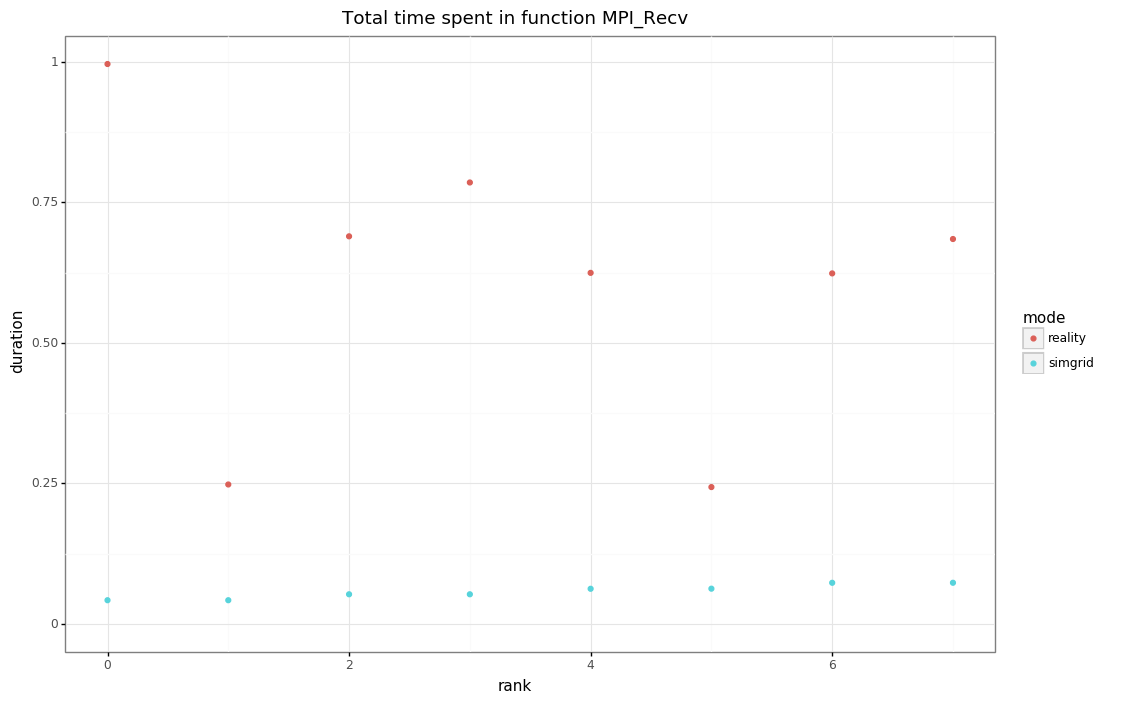

<ggplot: (8792500054073)>


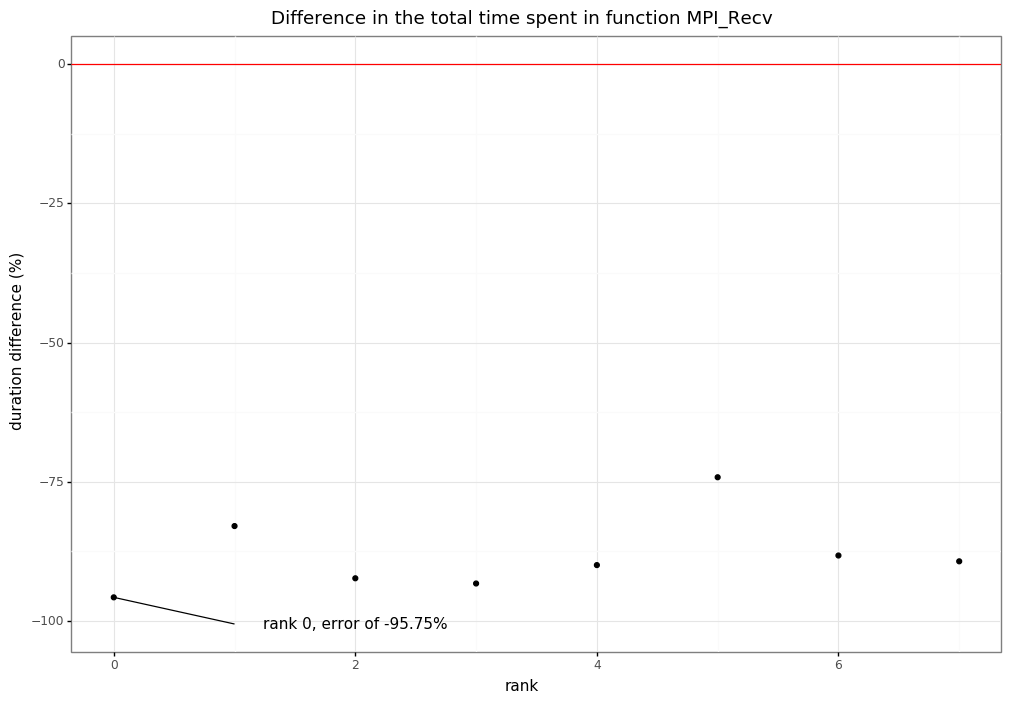

<ggplot: (-9223363244352052557)>


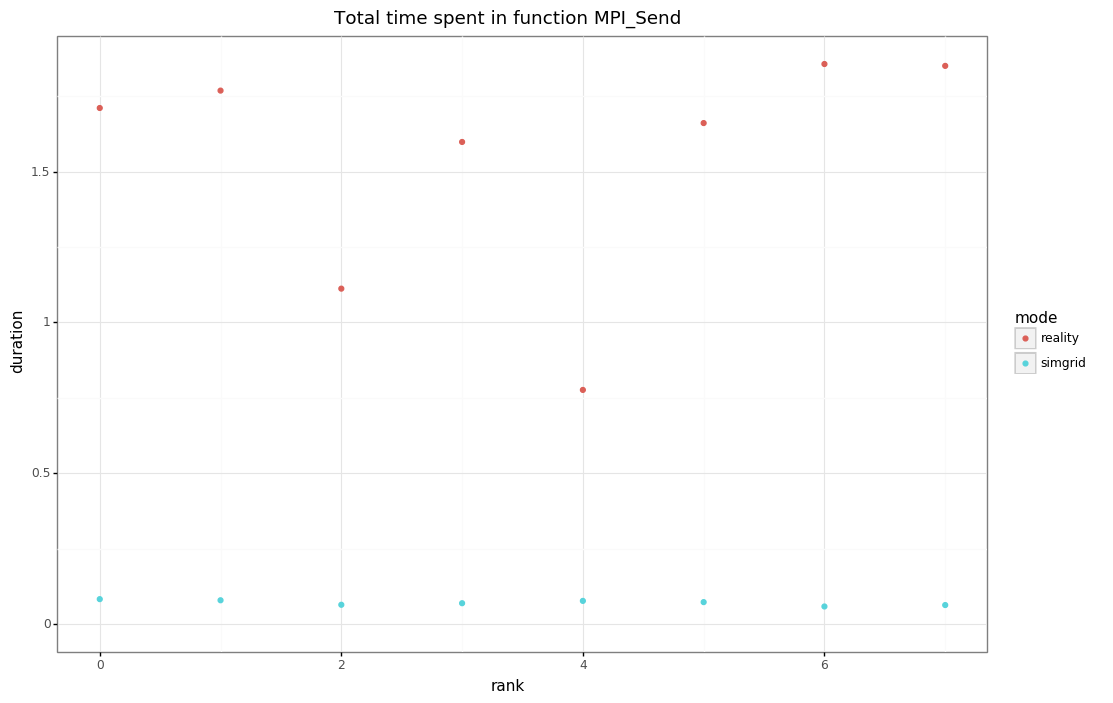

<ggplot: (8792502771748)>


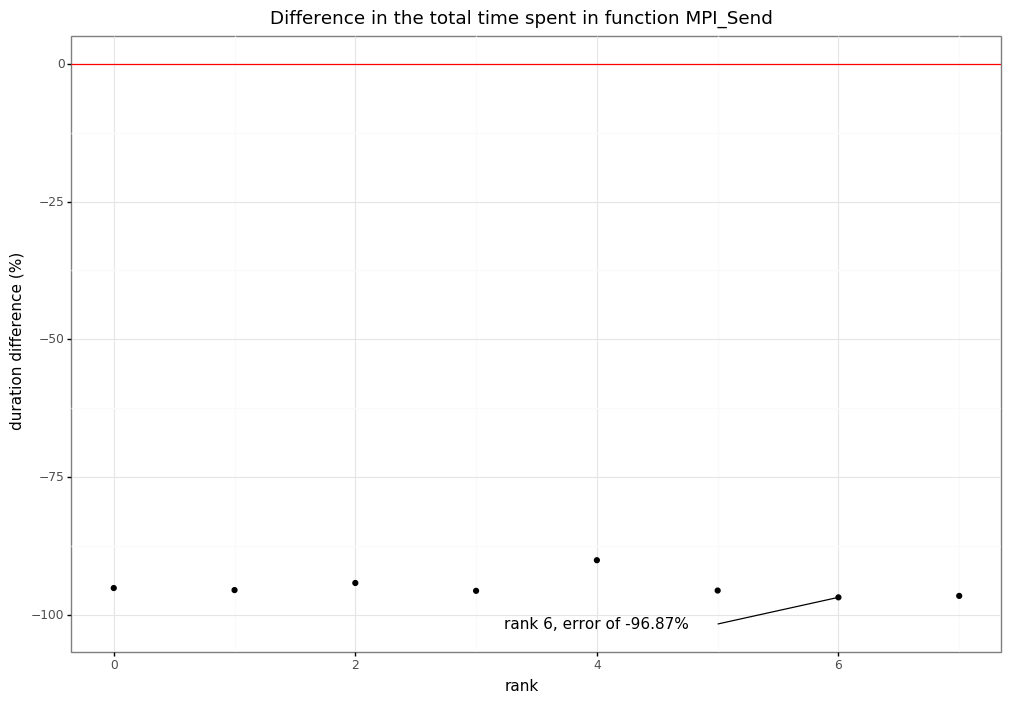

<ggplot: (-9223363244308624689)>


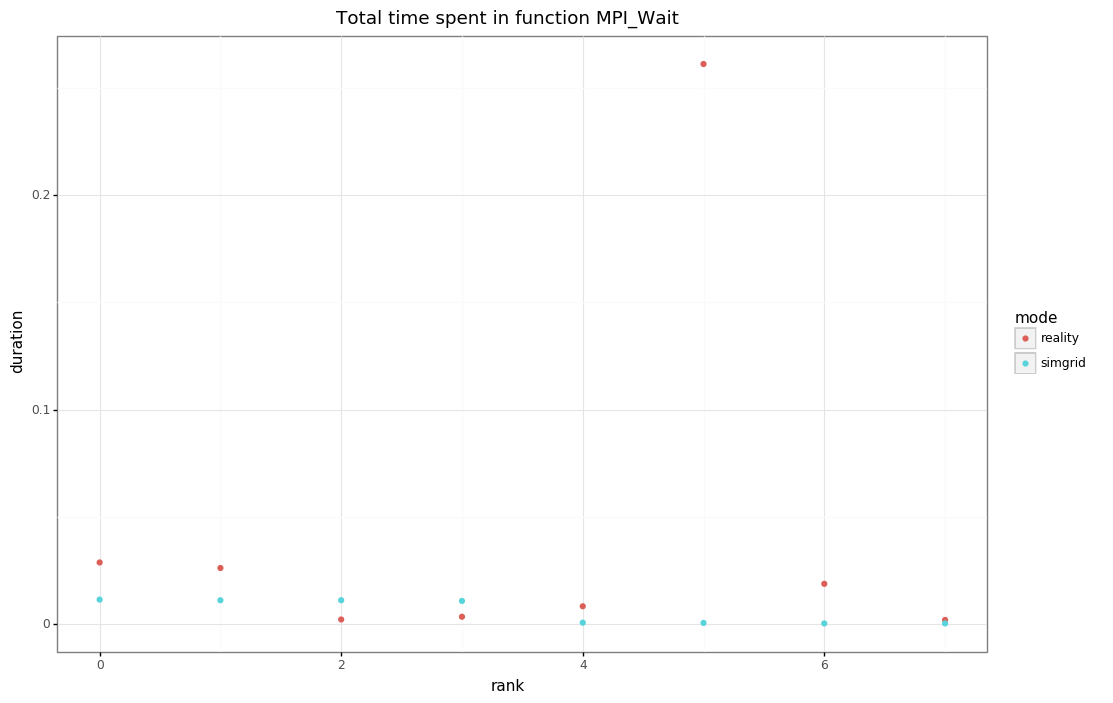

<ggplot: (-9223363244352025305)>


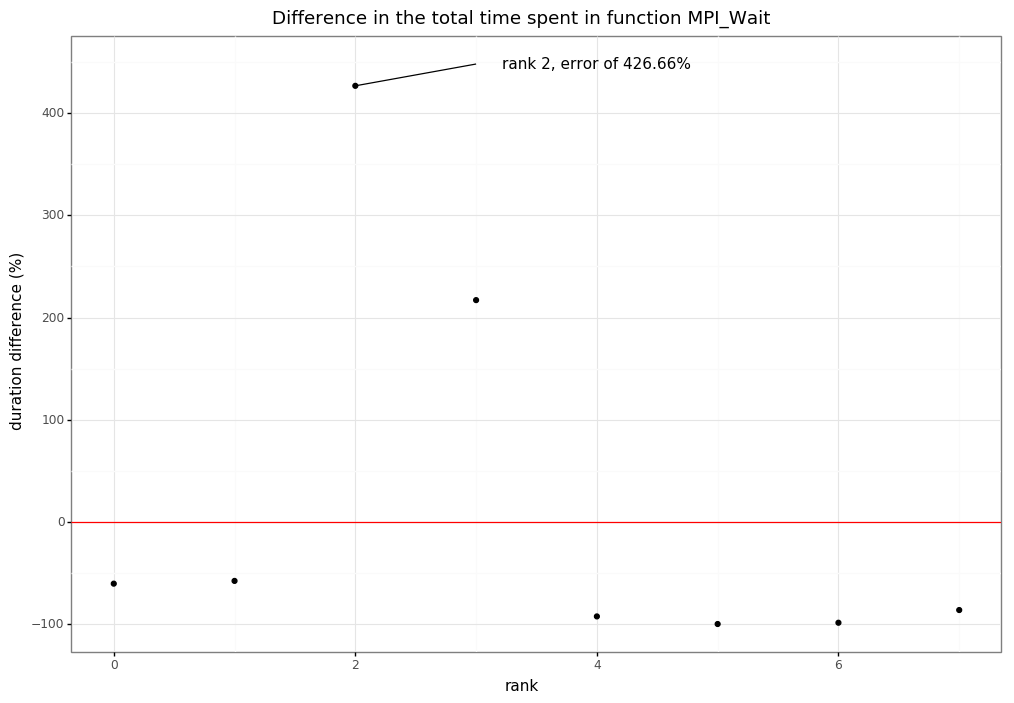

<ggplot: (8792502784306)>


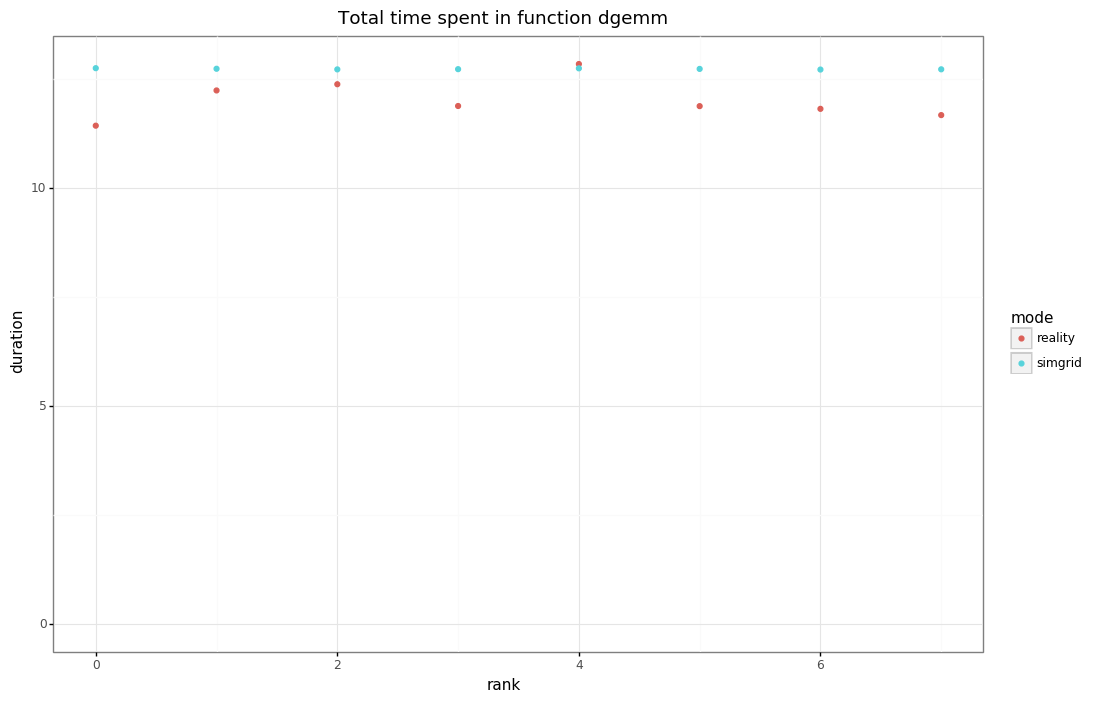

<ggplot: (8792565750862)>


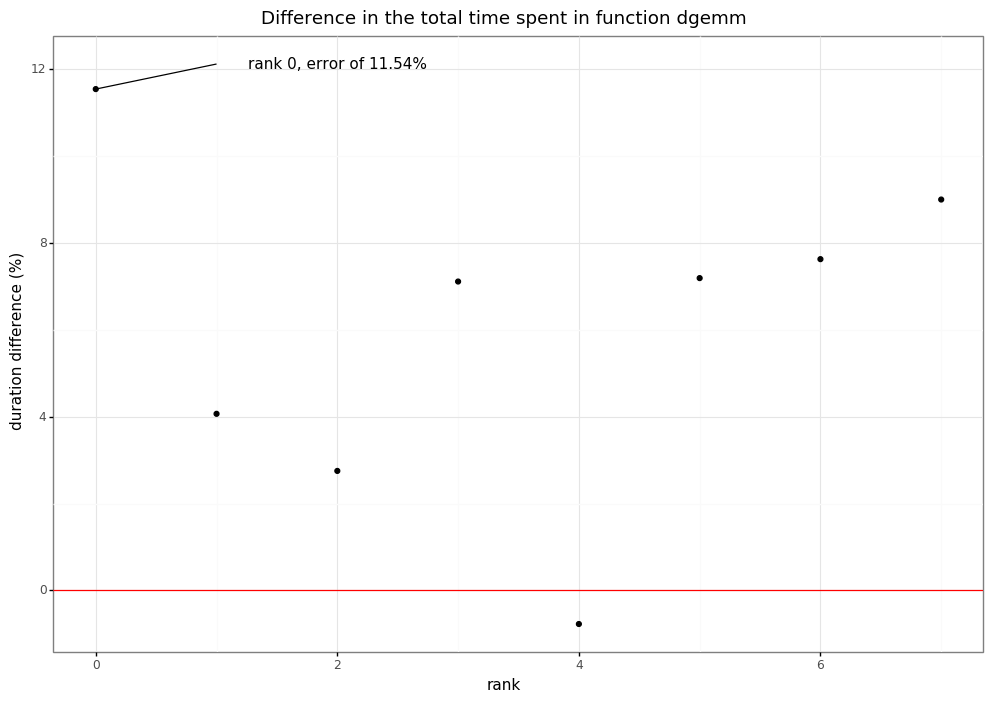

<ggplot: (-9223363244289032802)>


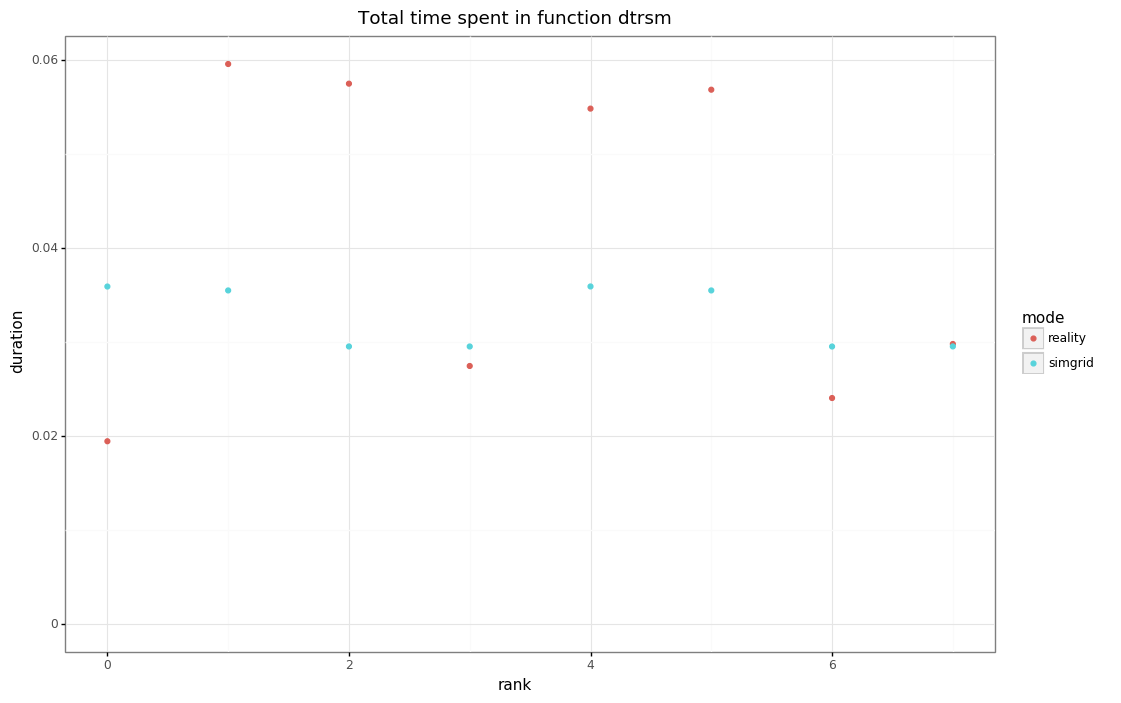

<ggplot: (-9223363244289032746)>


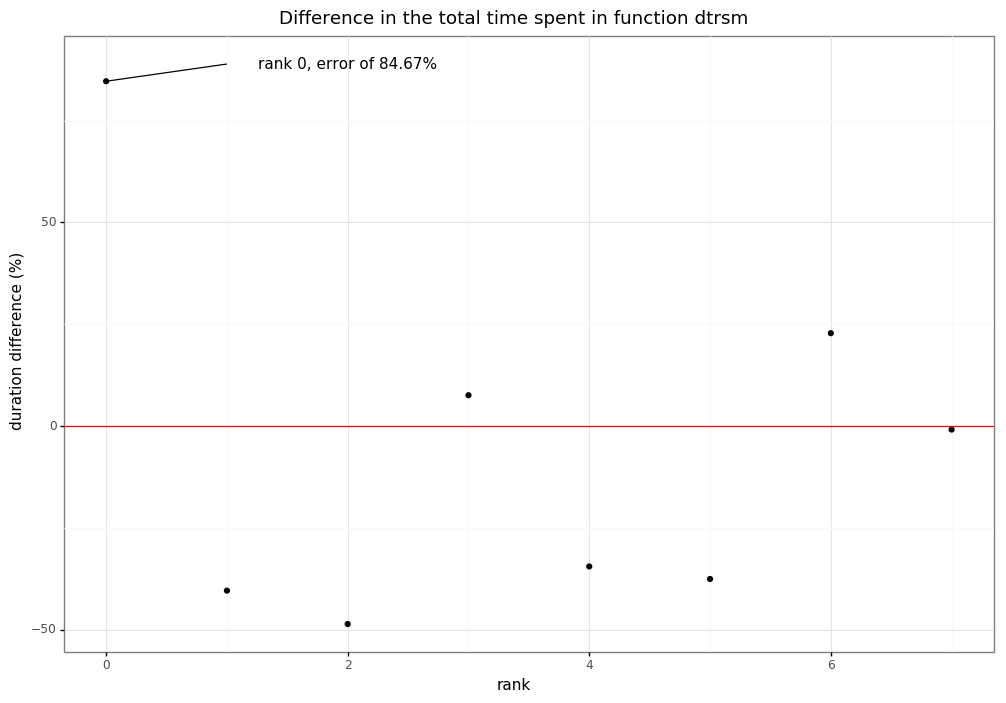

<ggplot: (-9223363244352050246)>


In [17]:
for func in sorted(set(trace_reality.function.unique()) & set(trace_simgrid.function.unique())):
    plot_total_duration(traces, func)

## Computing the average "bandwidth"

Here I divide the number of bytes sent (resp. received) by the time spent in MPI_Send (resp. MPI_Recv).
This does not make any sense for asynchronous calls, but this is roughly equal to the bandwidth for synchronous calls (neglecting the latency).

In [18]:
df = traces[traces.function.isin(['MPI_Recv', 'MPI_Send'])].copy()
df['duration'] = df['end'] - df['start']
df = df.groupby(['rank', 'mode', 'function']).sum().reset_index()
df_reality = df[df['mode'] == 'reality']
df_simgrid = df[df['mode'] == 'simgrid']
df = df_simgrid.set_index(['rank', 'function']).join(df_reality.set_index(['rank', 'function']), rsuffix='_reality').reset_index()
df['duration_simgrid'] = df['duration']
df['bw_simgrid'] = df['msg_size'] / df['duration_simgrid']
df['bw_reality'] = df['msg_size'] / df['duration_reality']
df[['rank', 'function', 'msg_size', 'duration_simgrid', 'duration_reality', 'bw_simgrid', 'bw_reality']]

,rank,function,msg_size,duration_simgrid,duration_reality,bw_simgrid,bw_reality
0,0,MPI_Recv,511709216,0.042306,0.996094,1.209543e+10,5.137158e+08
1,0,MPI_Send,832926784,0.082451,1.710491,1.010208e+10,4.869519e+08
2,1,MPI_Recv,511709216,0.042306,0.248193,1.209543e+10,2.061739e+09
3,1,MPI_Send,832584008,0.078680,1.768186,1.058190e+10,4.708690e+08
4,2,MPI_Recv,639636520,0.052884,0.689606,1.209509e+10,9.275391e+08
5,2,MPI_Send,704601144,0.063816,1.111711,1.104114e+10,6.337988e+08
6,3,MPI_Recv,639636520,0.052883,0.785369,1.209531e+10,8.144408e+08
7,3,MPI_Send,704601136,0.068948,1.597930,1.021931e+10,4.409462e+08
8,4,MPI_Recv,703139872,0.062697,0.624631,1.121489e+10,1.125688e+09
9,4,MPI_Send,767915048,0.076637,0.775965,1.002016e+10,9.896259e+08


In [19]:
df[['function', 'bw_simgrid', 'bw_reality']].groupby('function').mean()

,bw_simgrid,bw_reality
function,,
MPI_Recv,1.168051e+10,1.359603e+09
MPI_Send,1.046540e+10,5.218021e+08


We see here that the "average bandwidth" is about 10 GB/s in Simgrid and less than 500MB/s in reality. The Omnipath links that we have should be 100Gb/s (12.5 GB/s). So maybe we have a problem in reality? Maybe we don't use the right network interface?

In [20]:
matrix_size = read_csv(reality_file, 'exp.csv').matrix_size.unique()[0]
print(matrix_size)

250000


In [21]:
print(matrix_size ** 2 * 8)
print(df[df.function == 'MPI_Recv'].msg_size.sum())
print(df[df.function == 'MPI_Send'].msg_size.sum())

500000000000
5371321632
5888939648


I just checked above if the amount of data sent/received is "normal". For the whole execution, we expect it to be of the same order of magnitude as the memory occupation of the matrix (we did only 5 iterations here).

## Counting the number of events

In [22]:
traces[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode         
MPI_Irecv reality  1586
          simgrid  1556
MPI_Recv  reality  5895
          simgrid    51
MPI_Send  reality  7481
          simgrid  1607
MPI_Wait  reality  1586
          simgrid  1556
computing simgrid  4871
dgemm     reality  1781
          simgrid  1686
dtrsm     reality  1781
          simgrid  1686

WTF ?!

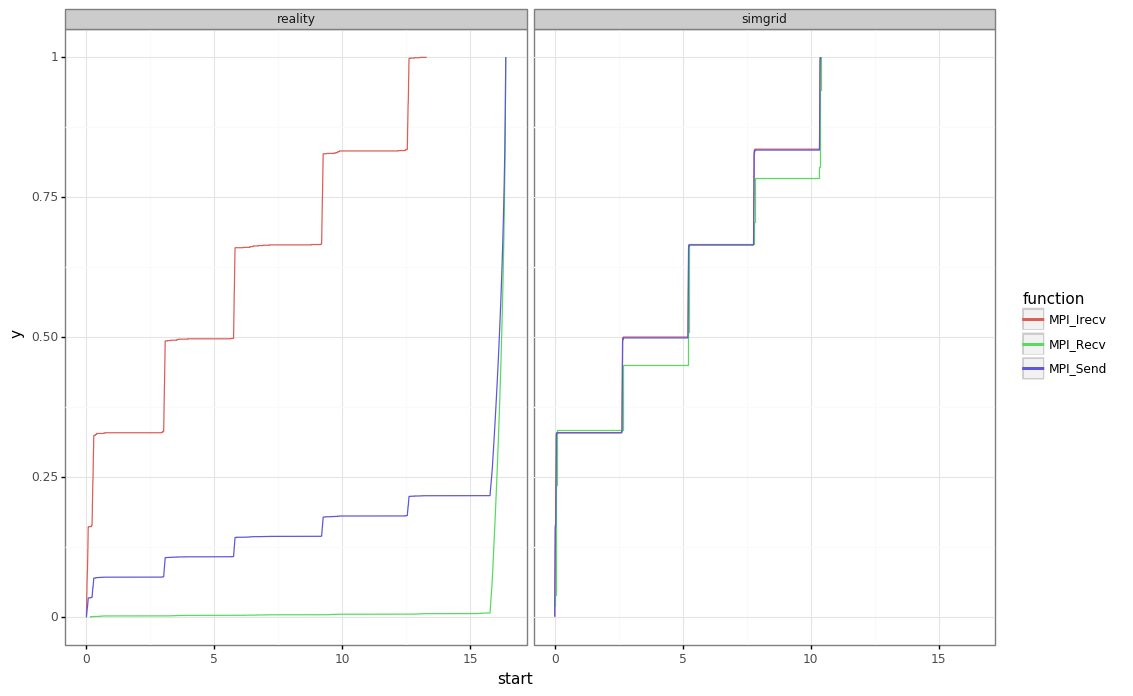

<ggplot: (-9223363244280733429)>

In [23]:
ggplot(traces[traces.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

Ok, there is obviously something wrong with the MPI_Recv and the MPI_Send near the end of the real experiment. Let's zoom on it.

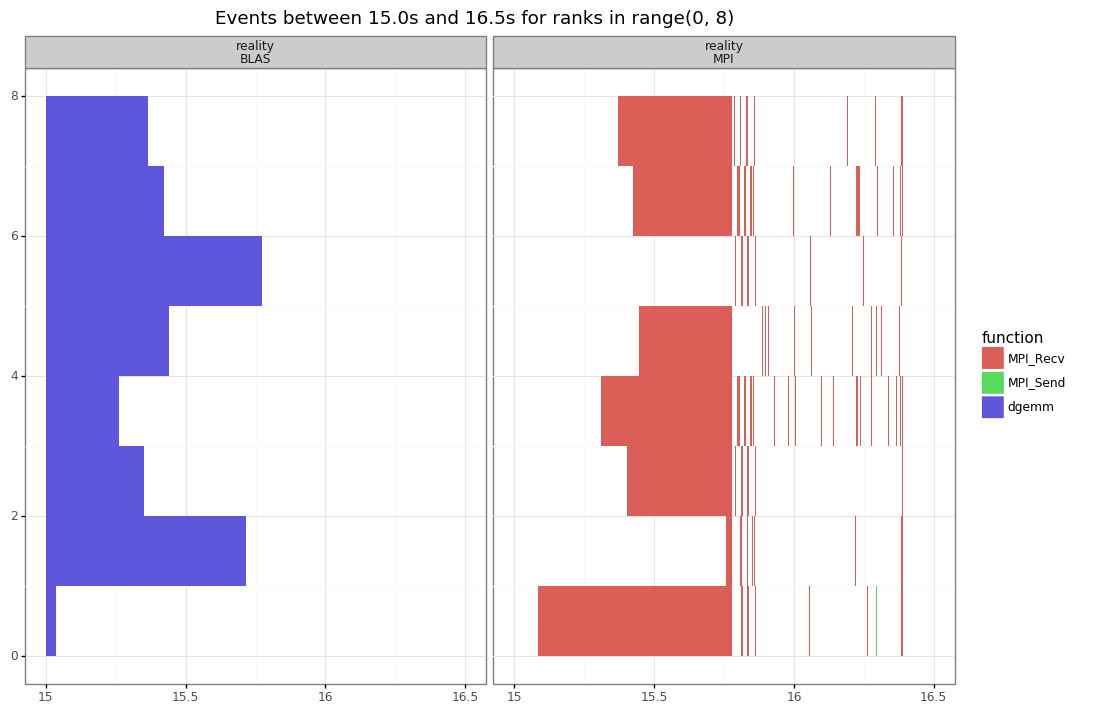

<ggplot: (8792509871522)>

In [24]:
plot_bounded(trace_reality, 15, 16.5, range(8))

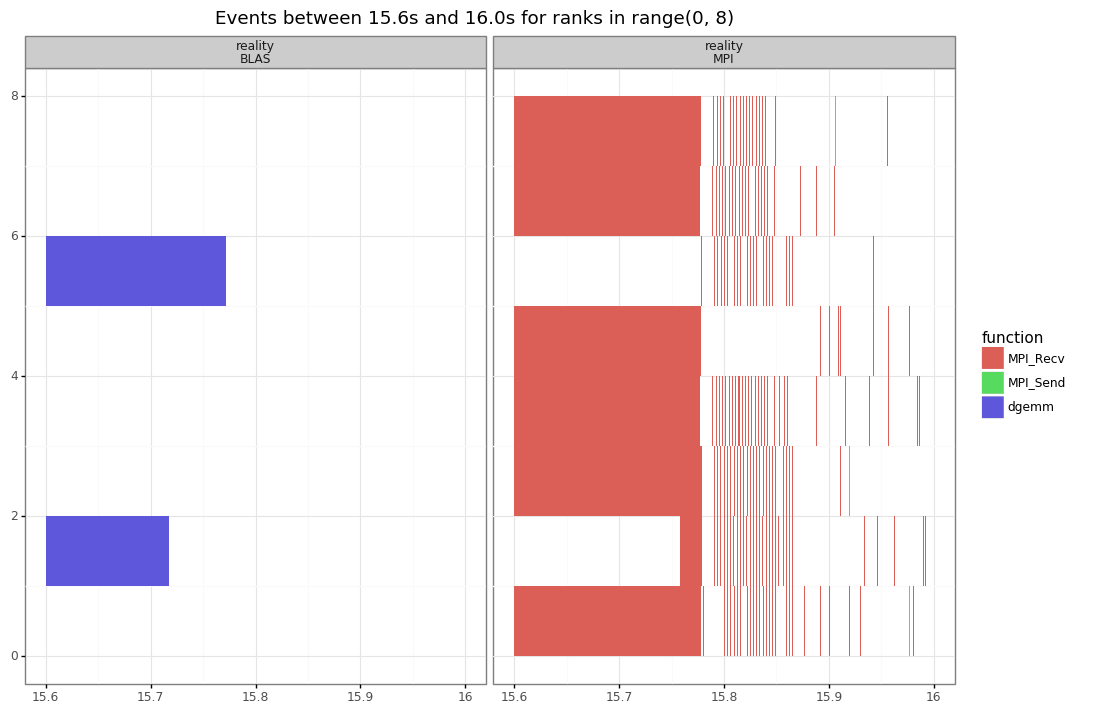

<ggplot: (-9223363244288502321)>

In [25]:
plot_bounded(trace_reality, 15.6, 16, range(8))

Ok, let's cut at 15.75s.

In [26]:
tmp = traces[traces['start'] <= 15.75]
tmp[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode         
MPI_Irecv reality  1586
          simgrid  1556
MPI_Recv  reality    42
          simgrid    51
MPI_Send  reality  1622
          simgrid  1607
MPI_Wait  reality  1586
          simgrid  1556
computing simgrid  4871
dgemm     reality  1781
          simgrid  1686
dtrsm     reality  1781
          simgrid  1686

The numbers for the simulation and the reality are a bit closer, but still significantly different: merging the two traces would be difficult.

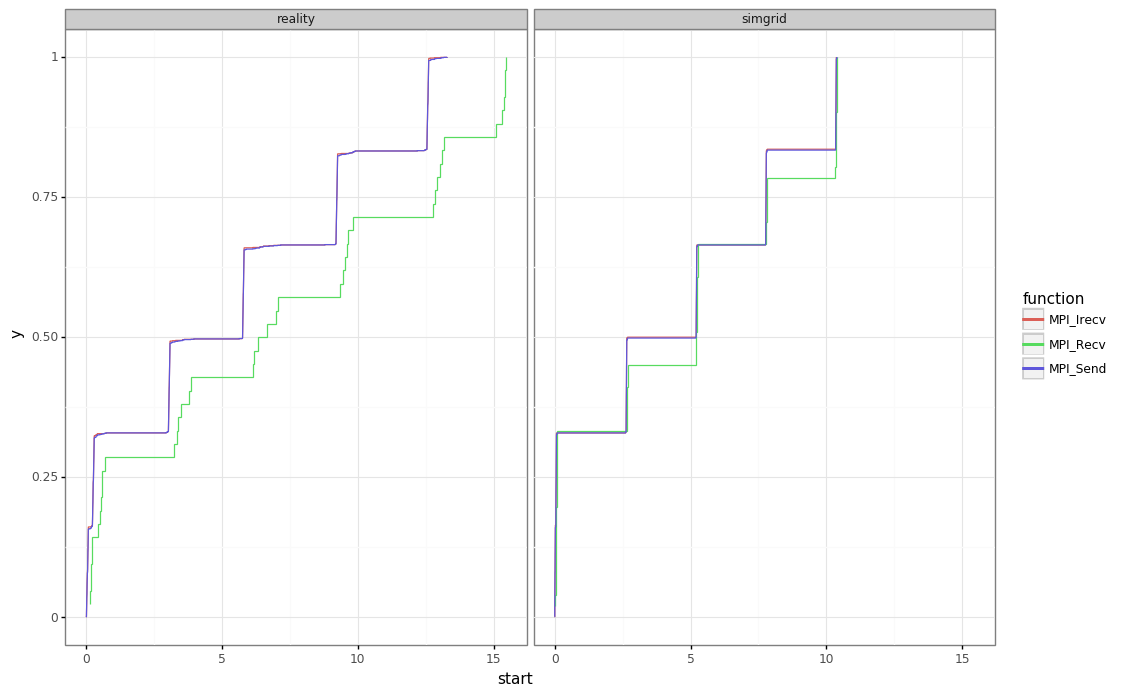

<ggplot: (8792565721976)>

In [27]:
ggplot(tmp[tmp.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

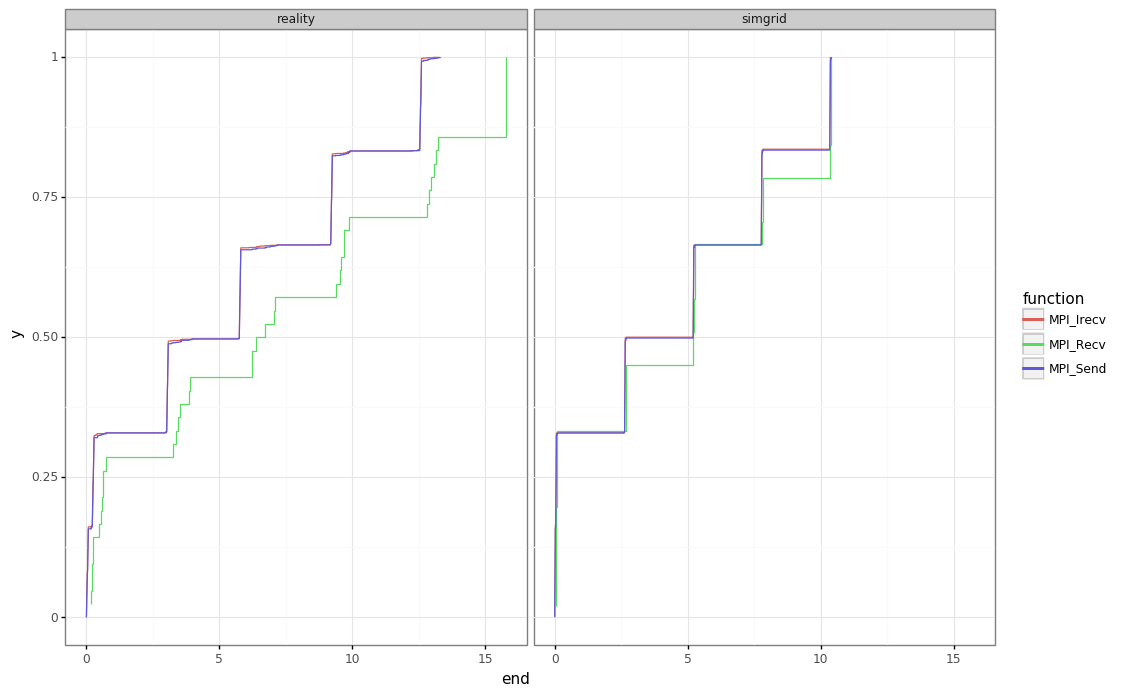

<ggplot: (-9223363244309002005)>

In [28]:
ggplot(tmp[tmp.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='end', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

In [29]:
trace_simgrid[trace_simgrid['rank'] == 0].sort_values(by=['start']).head(n=20)

,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1
0,0.000047,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,0.000000,simgrid,1
1,0.000189,dgemm,2.0,BLAS,125054.0,-1,2.0,0,0.000083,simgrid,1
2,0.000250,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,0.000205,simgrid,1
3,0.000363,dgemm,2.0,BLAS,125052.0,-1,0.0,0,0.000258,simgrid,1
8500,0.000363,MPI_Irecv,NaN,MPI,NaN,1056,NaN,0,0.000363,simgrid,1
8501,0.000364,MPI_Send,NaN,MPI,NaN,2080,NaN,0,0.000363,simgrid,1
8502,0.000365,computing,NaN,MPI,NaN,-1,NaN,0,0.000364,simgrid,1
8503,0.000367,MPI_Wait,NaN,MPI,NaN,-1,NaN,0,0.000365,simgrid,1
8504,0.000372,computing,NaN,MPI,NaN,-1,NaN,0,0.000367,simgrid,1
4,0.000415,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,0.000370,simgrid,1


In [30]:
trace_reality[trace_reality['rank'] == 0].sort_values(by=['start']).head(n=20)

,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1
18003,0.000004,MPI_Irecv,NaN,MPI,NaN,-1,NaN,0,0.000000,reality,1
18004,0.000020,MPI_Send,NaN,MPI,NaN,-1,NaN,0,0.000015,reality,1
18005,0.000048,MPI_Wait,NaN,MPI,NaN,-1,NaN,0,0.000026,reality,1
0,0.002777,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,0.002750,reality,1
1,0.003032,dgemm,2.0,BLAS,125054.0,-1,2.0,0,0.002750,reality,1
2,0.003750,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,0.003750,reality,1
3,0.003751,dgemm,2.0,BLAS,125052.0,-1,0.0,0,0.003750,reality,1
4,0.003752,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,0.003750,reality,1
5,0.003907,dgemm,4.0,BLAS,125052.0,-1,4.0,0,0.003750,reality,1
6,0.004751,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,0.004750,reality,1


We can find the same parameter values for the BLAS (m, n, k). However, the interleaving of the BLAS and MPI operations is not exactly the same in the two traces. My guess is that the measure of time is not the same for the BLAS and MPI traces. In particular, the origin (time 0) is not defined at the exact same time.